### NLP - Homework 7

#### Paritosh Rai¶

Cluster the reviews that you collected in homework 5, by doing the following:

In [55]:
# ignore warnnings
#https://queirozf.com/entries/suppressing-ignoring-warnings-in-python-reference-and-examples

import warnings

warnings.filterwarnings('ignore')

# no warnings will be printed from now on

In [56]:
# import required packages
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import itertools
import nltk
from nltk import word_tokenize
import spacy # import spacy
import spacy
#import required packages
from __future__ import print_function
from nltk import word_tokenize
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt #to plot bar chart and heatmap
import pandas as pd
%matplotlib inline
from sklearn.cluster import KMeans
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
import re
import os
import matplotlib as mpl
from sklearn.manifold import MDS
from matplotlib import font_manager as rcParams
import itertools
#load en_core_web_sm
nlp = spacy.load('en_core_web_sm')

pd.options.display.max_colwidth=500

In [57]:
def getSoup(url):
    """
    Utility function which takes a url and returns a Soup object.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    return soup

In [58]:
# API call to select:
## feature films
## which are rated atleast 4.0
## having atleast 50,000 votes
## in the romance genre
## sorted by user rating
## limit to 150 movies
url = '''https://www.imdb.com/search/title/?title_type=feature&user_rating=4.0,10.0
&num_votes=50000,view=simple&sort=user_rating,desc&count=150'''

# get the soup from url using 'getSoup' function
movies_soup = getSoup(url)
# print(movies_soup)

In [59]:
# Find all a-tag with class:None
movie_tags = movies_soup.find_all('a', attrs={'class': None})

#print(movie_tags)

# filter the a-tags to get just the titles
movie_tags = [tag.attrs['href'] for tag in movie_tags 
              if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]
#print(movie_tags)

# remove duplicate links
movie_tags = list(dict.fromkeys(movie_tags))
#print(movie_tags)

print("There are a total of " + str(len(movie_tags)) + " movie titles")
print("Displaying 10 titles")

movie_tags[:10]

There are a total of 150 movie titles
Displaying 10 titles


['/title/tt0111161/',
 '/title/tt0068646/',
 '/title/tt10189514/',
 '/title/tt0468569/',
 '/title/tt0071562/',
 '/title/tt0050083/',
 '/title/tt0167260/',
 '/title/tt0110912/',
 '/title/tt0108052/',
 '/title/tt1375666/']

In [60]:
# movie links
# use base_url+tag+review
base_url = "https://www.imdb.com"
movie_links = [base_url + tag + 'reviews' for tag in movie_tags]
print("There are a total of " + str(len(movie_links)) + " movie user reviews")
print("Displaying 10 user reviews links")
movie_links[:10]

There are a total of 150 movie user reviews
Displaying 10 user reviews links


['https://www.imdb.com/title/tt0111161/reviews',
 'https://www.imdb.com/title/tt0068646/reviews',
 'https://www.imdb.com/title/tt10189514/reviews',
 'https://www.imdb.com/title/tt0468569/reviews',
 'https://www.imdb.com/title/tt0071562/reviews',
 'https://www.imdb.com/title/tt0050083/reviews',
 'https://www.imdb.com/title/tt0167260/reviews',
 'https://www.imdb.com/title/tt0110912/reviews',
 'https://www.imdb.com/title/tt0108052/reviews',
 'https://www.imdb.com/title/tt1375666/reviews']

In [61]:
# function to find positive and negative review
def minMax(a):
    '''Returns the index of negative and positive review.'''
    
    # get the index of least rated user review
    minpos = a.index(min(a))
    
    # get the index of highest rated user review
    maxpos = a.index(max(a))
    
    return minpos, maxpos

In [62]:
def getReviews(soup):
    '''Function returns a negative and positive review for each movie.'''
    
    # get a list of user ratings
    user_review_ratings = [tag.previous_element for tag in 
                           soup.find_all('span', attrs={'class': 'point-scale'})]
    
    
    # find the index of negative and positive review
    n_index, p_index = minMax(list(map(int, user_review_ratings)))
    
    
    # get the review tags
    user_review_list = soup.find_all('a', attrs={'class':'title'})
    
    
    # get the negative and positive review tags
    n_review_tag = user_review_list[n_index]
    p_review_tag = user_review_list[p_index]
    
    # return the negative and positive review link
    n_review_link = "https://www.imdb.com" + n_review_tag['href']
    p_review_link = "https://www.imdb.com" + p_review_tag['href']
    return n_review_link, p_review_link
    

In [63]:
def getReviewText(review_url):
    '''Returns the user review text given the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find div tags with class text show-more__control
    tag = soup.find('div', attrs={'class': 'text show-more__control'})
    
    return tag.getText()

In [64]:
def getMovieTitle(review_url):
    '''Returns the movie title from the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find h1 tag
    tag = soup.find('h1')
    
    return list(tag.children)[1].getText()

In [65]:
def getNounChunks(user_review):
    
    # create the doc object
    doc = nlp(user_review)
    
    # get a list of noun_chunks
    noun_chunks = list(doc.noun_chunks)
    
    # convert noun_chunks from span objects to strings, otherwise it won't pickle
    noun_chunks_strlist = [chunk.text for chunk in noun_chunks]
    
    return noun_chunks_strlist

In [66]:
# get a list of soup objects
movie_soups = [getSoup(link) for link in movie_links]

# get all 150 movie review links
movie_review_list = [getReviews(movie_soup) for movie_soup in movie_soups]

movie_review_list = list(itertools.chain(*movie_review_list))
print(len(movie_review_list))

print("There are a total of " + str(len(movie_review_list)) + " individual movie reviews")
print("Displaying 10 reviews")
movie_review_list[:10]

300
There are a total of 300 individual movie reviews
Displaying 10 reviews


['https://www.imdb.com/review/rw6770639/',
 'https://www.imdb.com/review/rw0349418/',
 'https://www.imdb.com/review/rw1901277/',
 'https://www.imdb.com/review/rw3038370/',
 'https://www.imdb.com/review/rw6260561/',
 'https://www.imdb.com/review/rw6260603/',
 'https://www.imdb.com/review/rw6475511/',
 'https://www.imdb.com/review/rw6457886/',
 'https://www.imdb.com/review/rw0135590/',
 'https://www.imdb.com/review/rw5049900/']

In [67]:
# get review text from the review link
review_texts = [getReviewText(url) for url in movie_review_list]

# get movie name from the review link
movie_titles = [getMovieTitle(url) for url in movie_review_list]

# label each review with negative or positive
review_sentiment = np.array(['negative', 'positive'] * (len(movie_review_list)//2))

# construct a dataframe
df = pd.DataFrame({'movie': movie_titles, 'user_review_permalink': movie_review_list,
             'user_review': review_texts, 'sentiment': review_sentiment})

In [68]:
df.head()

,movie,user_review_permalink,user_review,sentiment
0,The Shawshank Redemption,https://www.imdb.com/review/rw6770639/,"If you like hopeful, surprising, never-seen-before characters, you will enjoy this amusing story of a family of prisoners victimized by the system and a Bible thumping pig.Robbins and Freeman, and everybody else, gives perfect performances for their characters. Their actions and body languages are perfect for this story and movie.",negative
1,The Shawshank Redemption,https://www.imdb.com/review/rw0349418/,"Why do I want to write the 234th comment on The Shawshank Redemption? I am not sure - almost everything that could be possibly said about it has been said. But like so many other people who wrote comments, I was and am profoundly moved by this simple and eloquent depiction of hope and friendship and redemption. The only other movie I have ever seen that effects me as strongly is To Kill a Mockingbird. Both movies leave me feeling cleaner for having watched them.I didn't intend to see this mo...",positive
2,The Godfather,https://www.imdb.com/review/rw1901277/,"""The Godfather"" simply put, is one of the greatest films of all time. The script is thee best I've ever read. The direction is flawless. The acting may very well have the best ensemble cast in any movie I've ever seen or will ever see. It's also one of the most precise and intricate films I've ever come across as writer, Mario Puzo brings out some of the most hidden and guarded secrets of the underground world ever captured on film. Watching ""The Godfather,"" is like watching cinematic art. F...",negative
3,The Godfather,https://www.imdb.com/review/rw3038370/,"'The Godfather' is the pinnacle of flawless films! The first time I viewed 'The Godfather' I was in my early teens and it was the most astounding film I had ever seen, and has since then stood as my all-time favourite film. It is due to this that I have been looking forward to writing a review of this unforgettable classic. So let's start from the beginning. The film opens to four words, 'I believe in America', it's crazy to think that this simple line has become a resonant quote solely due ...",positive
4,Soorarai Pottru,https://www.imdb.com/review/rw6260561/,Wonderful motivational story. Especially wonderful acting mr.suriya in airports scenes.,negative


In [69]:
df.shape

(300, 4)

In [70]:
user_review = df.user_review

In [71]:
user_review.shape

(300,)

In [72]:
#user_review

In [73]:
#Text Preprocessing

#load stop word libary
stop_words = nltk.corpus.stopwords.words('english')
# define the function to normalize the text
def normalize_document(doc):
 # lower case and remove special characters\whitespaces
 doc = re.sub(r'[^a-zA-Z0-9\s]',"",doc, re.I|re.A) # remove special characters and white space
 doc = doc.lower() # lower case
 doc = doc.strip()
 # tokenize document
 tokens = nltk.word_tokenize(doc)
 # filter stopwords out of document
 filtered_tokens = [token for token in tokens if token not in stop_words]
 # re-create document from filtered tokens
 doc = ' '.join(filtered_tokens)
 return doc
#normailize the text
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(user_review)
tokens = nltk.word_tokenize('norm_corpus')
len(norm_corpus) # check lenght to ensure there is data in the tozanized text

300

In [74]:
#norm_corpus

In [75]:
#  leverage TF_IDF to vectorize our preprocessed movie descriptions, thereby converting them into numeric vectors
#define vectorizer parameters

vec = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, max_features=200000, min_df=0.10)
reviews_tfidf_matrix = vec.fit_transform(norm_corpus) #fit the vectorizer to synopses
reviews_tfidf_matrix.shape # check shape to valiadate data in matrix

(300, 205)

In [76]:
#gather the different terms from the TF-IDF matrix and calculate cosine similarity distances based on the matrix.
terms = vec.get_feature_names()
dist = 1 - cosine_similarity(reviews_tfidf_matrix)

In [77]:
MDS()
# convert two components as we're plotting points in a two-dimensional plane leveraging MDS (Multidimenstional scaling)
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
#pos

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(300, 901)

In [80]:
#km.labels_.tolist()

In [81]:
#print(tfidf_matrix)

In [82]:
#print(cv_matrix)

##### 1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

In [83]:
# K- Mean Clustering
# 
from sklearn.cluster import KMeans
NUM_CLUSTERS = 5 # number of cluster
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(cv_matrix)
km
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
 n_clusters=NUM_CLUSTERS, n_init=50, n_jobs=None, precompute_distances='auto',
 random_state=42, tol=0.0001, verbose=0)
norm_corpus= km.labels_
#km

In [84]:
# viewing distribution of movies across the clusters
from collections import Counter
Counter(km.labels_)

Counter({4: 167, 2: 37, 0: 18, 1: 76, 3: 2})

In [85]:
#km.labels_

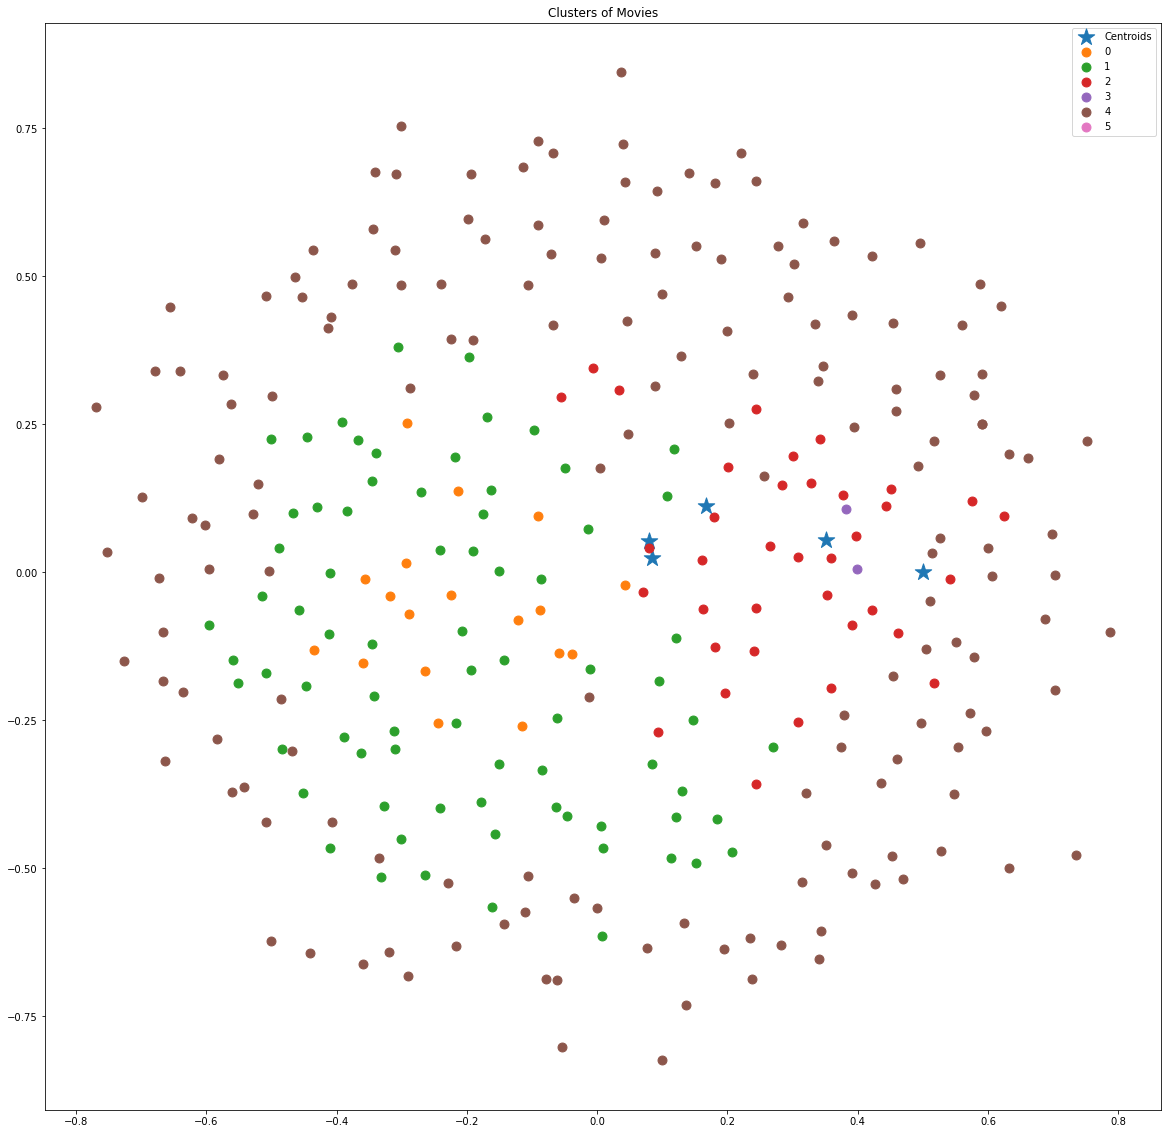

In [86]:
plt.figure(figsize=(20, 20))
#filter rows of original data
filtered_label0 = pos[km.labels_== 0]
filtered_label1 = pos[km.labels_== 1]
filtered_label2 = pos[km.labels_== 2]
filtered_label3 = pos[km.labels_== 3]
filtered_label4 = pos[km.labels_== 4]
filtered_label5 = pos[km.labels_== 5]

#Plotting the results#plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red')
plt.title('Clusters of Movies')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=300, label = 'Centroids', marker="*")
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], s=80, label = '0')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], s=80, label = '1')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], s=80, label = '2')
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1], s=80, label = '3')
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1], s=80, label = '4')
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1], s=80, label = '5')
'''plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'orange')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'blue')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'green')
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1] , color = 'black')
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1] , color = 'yellow')
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1] , color = 'red')'''
plt.legend()
plt.show()


### Following is view with 5 cluster

As we know, cluster distribution will change with every iteration, as initial centroid selection may vary from iteration to iteration. The image below was captured in one of the runs to demonstrate the clustering and basing logic for future answers. 

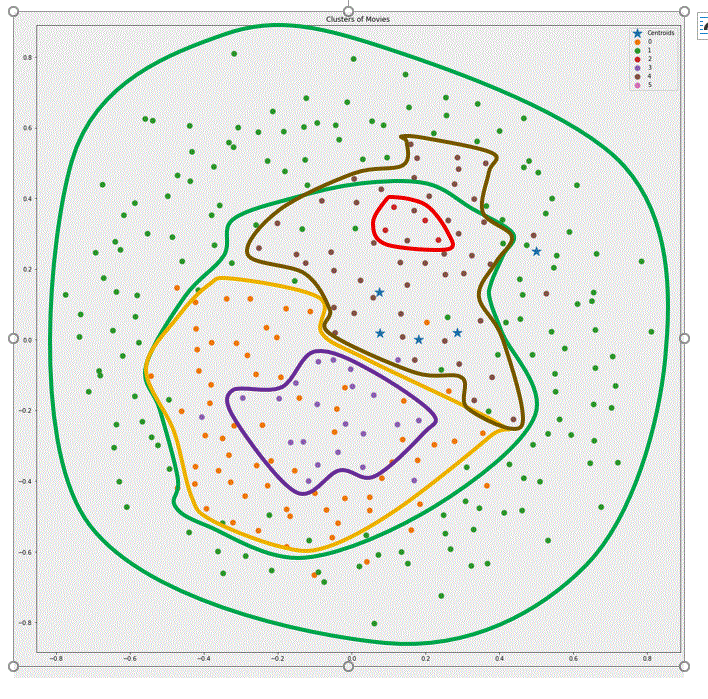

In [87]:
#Getting unique labels
 
u_labels = np.unique(km.labels_)
print(u_labels)
#plotting the results:
 
'''for i in u_labels:
    plt.scatter(df[km.labels_ == i , 0] , df[km.labels_ == i , 1] , km.labels_ = i)
plt.legend()
plt.show()'''

[0 1 2 3 4]


'for i in u_labels:\n    plt.scatter(df[km.labels_ == i , 0] , df[km.labels_ == i , 1] , km.labels_ = i)\nplt.legend()\nplt.show()'

In [88]:
#  to group similar movies in clusters

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_features = cosine_similarity(cv_matrix)
km = KMeans(n_clusters=NUM_CLUSTERS , max_iter=100000, n_init=50, random_state=42).fit(cosine_sim_features)
Counter(km.labels_)
Counter({4: 427, 3: 724, 1: 1913, 2: 504, 0: 879, 5: 353})
df['kmeans_cluster'] = km.labels_
movie_clusters = (df[['movie', 'kmeans_cluster']]
 .sort_values(by=['kmeans_cluster'],
 ascending=False)
 .groupby('kmeans_cluster').head(20))
movie_clusters = movie_clusters.copy(deep=True)
# get movies belonging to each cluster
for cluster_num in range(NUM_CLUSTERS ):
 movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['movie'].values.tolist()
 print('CLUSTER #'+str(cluster_num+1))
 print('Popular Movies:', movies)
 print('-'*80)

CLUSTER #1
Popular Movies: ['The Dark Knight', 'Amélie', '12 Angry Men', 'American Beauty', 'Soorarai Pottru', 'Inglourious Basterds', 'Soorarai Pottru', 'City of God', 'Hamilton', 'Braveheart', 'Star Wars: Episode VI - Return of the Jedi', 'Fight Club', 'Star Wars: Episode VI - Return of the Jedi', 'Gladiator', 'Your Name.', 'A Clockwork Orange', 'The Departed', 'Your Name.', 'Zindagi Na Milegi Dobara', 'Indiana Jones and the Raiders of the Lost Ark']
--------------------------------------------------------------------------------
CLUSTER #2
Popular Movies: ["One Flew Over the Cuckoo's Nest", 'Parasite', "One Flew Over the Cuckoo's Nest", 'Toy Story 3', 'The Dark Knight Rises', 'A Beautiful Mind', 'Memento', 'Toy Story 3', 'Gangs of Wasseypur', 'Zindagi Na Milegi Dobara', 'Goodfellas', 'Princess Mononoke', 'Like Stars on Earth', 'Inception', 'The Shining', "Howl's Moving Castle", 'Avengers: Infinity War', 'The Intouchables', 'Spider-Man: Into the Spider-Verse', 'The Lion King']
------

In the analysis above, five clusters were formed. There is an outer cluster and followed by two clusters inside the outer ring of the clusters. Each cluster has a sub-cluster inside each cluster. 

### Elbow Method for Optimal K

To find best number of cluster Elbow method was used. Change in slope of Sum of square of distance was observed at three cluster and five cluster. Above effort was made with five cluster. With five cluster two small clusters were formed.cluster 2 was with 4 movies and and cluster 3 was with 22 movies. 

In [89]:
md=[]
for i in range(1,21):
  km=KMeans(n_clusters=i)
  km.fit(cv_matrix)
  o=km.inertia_
  md.append(o)
print(md)

[52147.68000000001, 48050.022516009034, 45109.25115511549, 43971.635297157016, 43333.82953451041, 42254.68313283971, 41939.60747041418, 41254.36714574899, 41240.86751932277, 40405.142037007616, 39801.595129927126, 39428.55894034965, 39168.18000813082, 38747.75722606844, 37945.281543355304, 37475.87085800228, 36974.224969337345, 36578.46989538238, 36248.74806031329, 35767.96698025775]


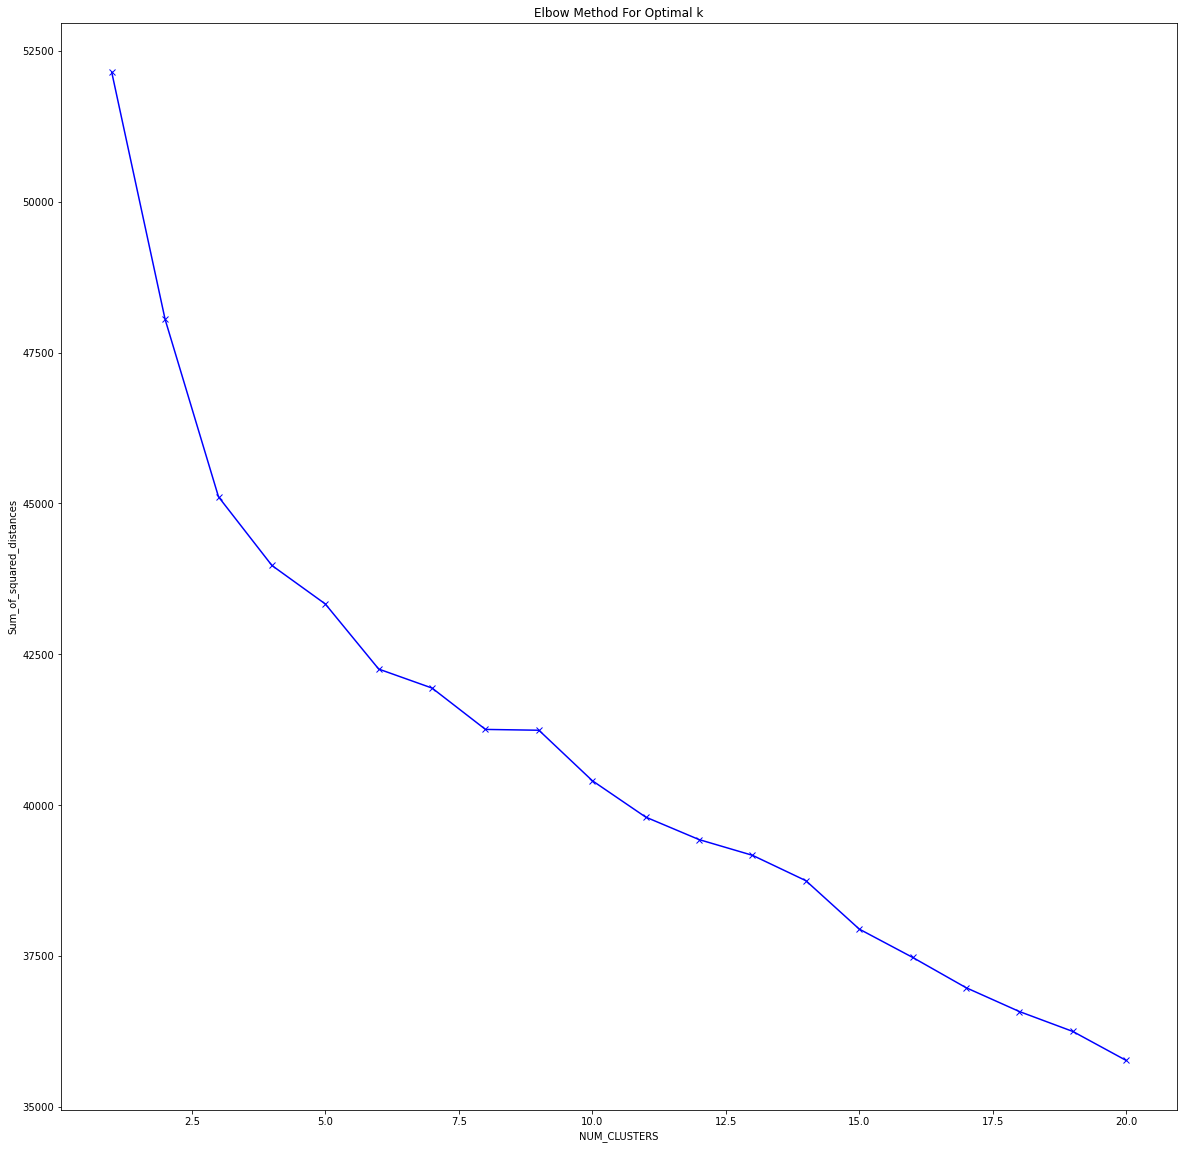

In [90]:
plt.figure(figsize=(20, 20))
plt.xlabel('NUM_CLUSTERS')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.plot(list(np.arange(1,21)),md,'bx-')
plt.show()

There are two places were it makes sense to break the slope one at five(5) clutser and other one at threec(3) cluster 

### Three (3) Cluster View

Re-running the KMean with three (3) cluster

In [91]:
# K- Mean Clustering
from sklearn.cluster import KMeans
NUM_CLUSTERS = 3 # number of cluster
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(cv_matrix)
km
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
 n_clusters=NUM_CLUSTERS, n_init=50, n_jobs=None, precompute_distances='auto',
 random_state=42, tol=0.0001, verbose=0)
norm_corpus= km.labels_
#km

In [92]:
# viewing distribution of movies across the clusters
from collections import Counter
Counter(km.labels_)

Counter({2: 202, 1: 68, 0: 30})

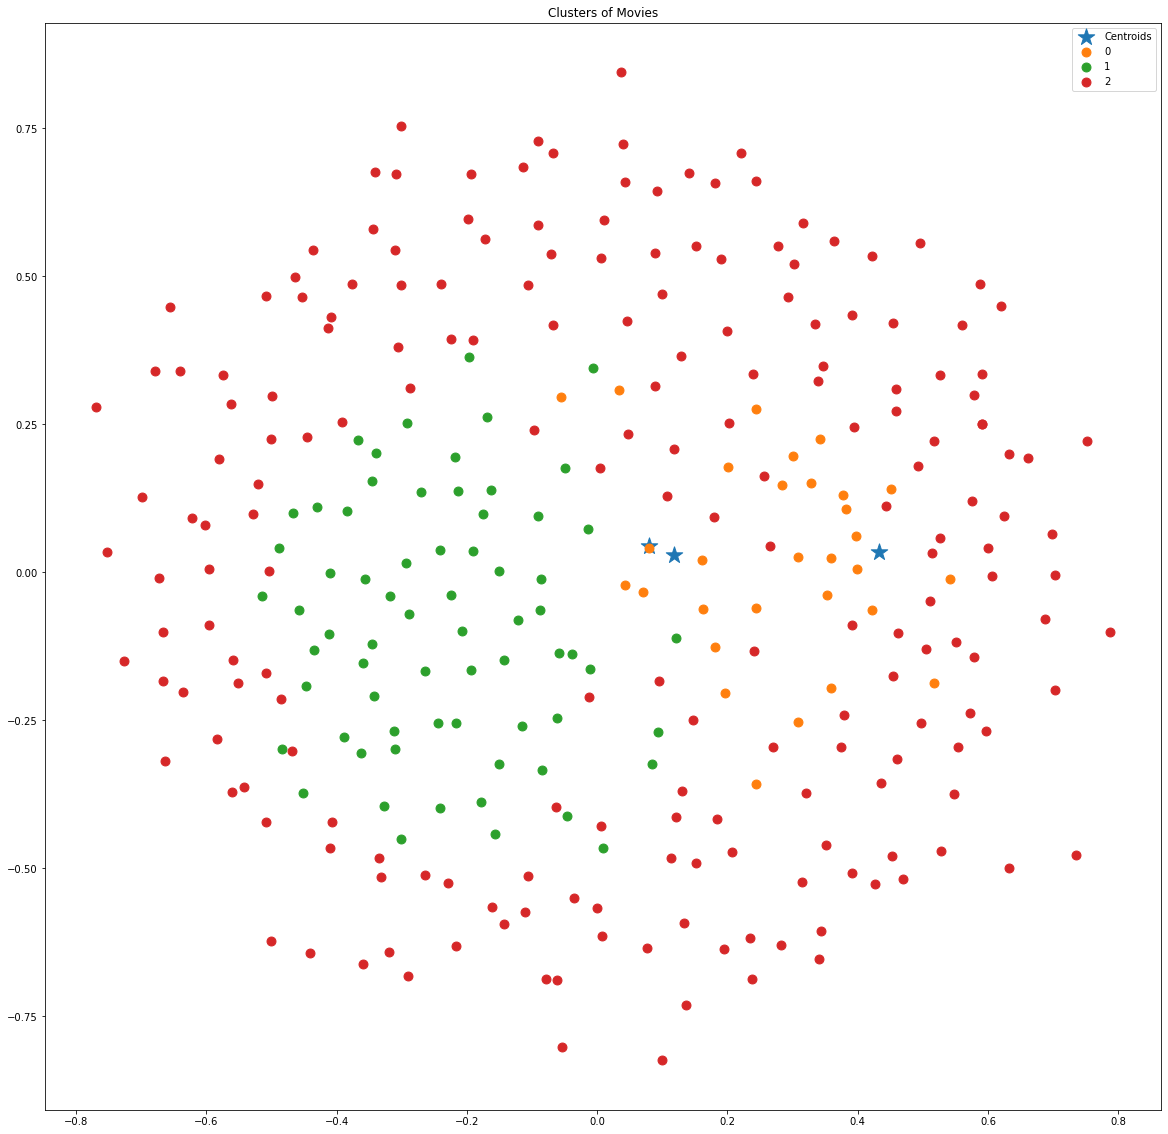

In [93]:
plt.figure(figsize=(20, 20))
#filter rows of original data
filtered_label0 = pos[km.labels_== 0]
filtered_label1 = pos[km.labels_== 1]
filtered_label2 = pos[km.labels_== 2]

#Plotting the results#plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red')
plt.title('Clusters of Movies')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=300, label = 'Centroids', marker="*")
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], s=80, label = '0')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], s=80, label = '1')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], s=80, label = '2')
plt.legend()
plt.show()

### Following is view with 5 cluster

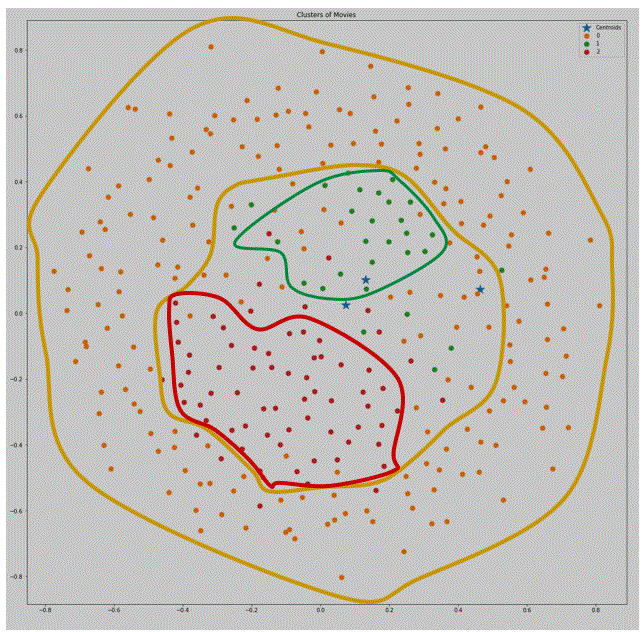

In [94]:
#  to group similar movies in clusters

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_features = cosine_similarity(cv_matrix)
km = KMeans(n_clusters=NUM_CLUSTERS , max_iter=100000, n_init=50, random_state=42).fit(cosine_sim_features)
Counter(km.labels_)
Counter({4: 427, 3: 724, 1: 1913, 2: 504, 0: 879, 5: 353})
df['kmeans_cluster'] = km.labels_
movie_clusters = (df[['movie', 'kmeans_cluster']]
 .sort_values(by=['kmeans_cluster'],
 ascending=False)
 .groupby('kmeans_cluster').head(20))
movie_clusters = movie_clusters.copy(deep=True)
# get movies belonging to each cluster
for cluster_num in range(NUM_CLUSTERS ):
 movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['movie'].values.tolist()
 print('CLUSTER #'+str(cluster_num+1))
 print('Popular Movies:', movies)
 print('-'*80)

CLUSTER #1
Popular Movies: ['Lock, Stock and Two Smoking Barrels', 'Joker', 'The Lion King', 'Bhaag Milkha Bhaag', 'Back to the Future', 'Inception', 'Back to the Future', 'Grave of the Fireflies', 'The Bandit', 'The Bandit', 'Queen', 'Grave of the Fireflies', 'Dangal', 'Drishyam', 'The Lion King', 'Casino', 'Capharnaüm', 'The Godfather: Part II', 'Pulp Fiction', 'Shutter Island']
--------------------------------------------------------------------------------
CLUSTER #2
Popular Movies: ['Inception', 'Star Wars: Episode VI - Return of the Jedi', 'The Dark Knight', 'Scarface', 'The Dark Knight', "Howl's Moving Castle", 'Star Wars: Episode VI - Return of the Jedi', 'Taxi Driver', 'Parasite', 'The Godfather: Part II', 'Amadeus', 'Full Metal Jacket', 'Hera Pheri', '12 Angry Men', 'Cinema Paradiso', 'City of God', 'Braveheart', 'Hera Pheri', 'Toy Story', 'Soorarai Pottru']
--------------------------------------------------------------------------------
CLUSTER #3
Popular Movies: ['Dr. Stran

##### 2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 

I am not big on the movies, so I have a limited understanding of moves. However, make an effort to explain the classification. The above categorization may not match with the observation below as results keep changing with iteration, as described above.

Cluster #1 contains movies on army or war scenarios, Saving Private Ryan, Baahubali, Bhaag Milkha Bhaag, Lord of Rings, and The return on the ling.

Cluster #2 is drama and space movies like star war, A Space Odyssey. It may be a fiction movies bucket. 

Cluster #3 is more of action movies. L.A Confidential, 1917, Heat, A Beautiful Mind, The Father and others

However, the cluster is based on user review, so it may not be an effective way to cluster correctly. A summary of the movie or multiple reviews of the same movie may add additional information for better categorization. As we know, KMean gets affected by extreme values and data imbalance that can square the outcome. The effort was made to normalize the extreme value. However, for five clusters K-Mean, we have a larger sample in cluster #1, and three cluster examples, cluster #0, have a larger number of samples than other clusters. K-Mean bring in some challenges, and we have to be careful about them:

* k-mean depends on where we chose inia values. So a section of the initial value can have a huge impact 
* As in our case above, we have varying sizes and densities of clusters that can have an impact on the final outcome
* Base data is NLP (text from review), so we can have extreme data. However, we made an effort to minimize the outlier of extreme values by normalizing the text. 



##### 3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 

The effort was made to run K-Mean using two different cluster numbers, five(5) and three(3). Both numbers were recommended by the Elbow method as a change in slope was observed in both analyses. We removed genre filtering from the data to get better dispersion of data, hoping that it will help with categorization. 

Neither five(5) clusters and three(3) clusters K-Mean gave us perfect isolated clusters, and both had areas of overlap.  However, However, I am leaning towards three(3) cluster K-Mean as it has better distribution and isolation. In three cluster analyses based on reviews, we can put the movies in three (3) clusters, war-or army-based movies,   friction movies, drama, and space cluster. 

In five(5) clusters K-Mean analysis, it was very challenging to categorize the movies. It starts with one form and gets converted to another category.  That may be, as the movies get away from centroid, they become more closer to another centroid. Also, some of the clusters in the five (5) clusterings are very small {4: 167, 2: 37, 0: 18, 1: 76, 3: 2}. Whereas in three (3) clusters, K-Mean cluster size ae substantial {2: 202, 1: 68, 0: 30}. As we know, cluster formation depends on two factors, similarity, and difference. 

Leveraging genre, director, and movie summary might be a better methodology to cluster the movies. Also, reviews were done by different people with different levels of English language understanding that can have a significant impact on clustering. 